In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# loading datasets and preliminary cleaning
rotten=pd.read_csv('../../data/rotten_tomatoes_movies.csv')
rotten=rotten.drop(['rotten_tomatoes_link', 'content_rating', 'actors', 'streaming_release_date', 
                    'movie_info', 'critics_consensus', 'genres', 'directors', 'authors',# 'original_release_date',  
                    'production_company', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count'], axis=1)


meta=pd.read_csv('../../data/movies_meta.csv')
meta=meta.loc[meta['original_language']=='en']  # only english movies
meta=meta.drop(['production_countries', 'overview', 'tagline', 'belongs_to_collection', 'homepage', 'revenue', 'spoken_languages', 'video', 'homepage', "poster_path", 'production_companies'], axis=1)


### Preprocessing the datasets

In [3]:
genres=['Action',  'History', 'Adventure',  'Horror', 'Adult',  'Music', 'Animation',  'Musical', 'Biography',  'Mystery', 'Comedy',  'Romance', 
'Crime',   'Sci-Fi', 'Documentary',  'Short', 'Drama',  'Sport',  'Family',  'Thriller', 'Fantasy',  'Film-noir',    
'History',  'Horror', 'Music', 'Mystery', 'Romance',  'Short',  'War', 'Western', 'Science Fiction']

for i in genres:
    meta[i]=0

for idx, row in enumerate(meta['genres'][:20]):

    meta[row.split("'")[5]][idx]=1
    try:
        meta[row.split("'")[11]][idx]=1
    except IndexError:
        pass
    try:
        meta[row.split("'")[17]][idx]=1
    except IndexError:
        pass
    
print(meta)

      adult    budget                                             genres  \
0     False  30000000  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1     False  65000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2     False  58000000  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...   
3     False   3600000  [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...   
4     False  29500000  [{'id': 878, 'name': 'Science Fiction'}, {'id'...   
...     ...       ...                                                ...   
4684  False         0                      [{'id': 18, 'name': 'Drama'}]   
4685  False         0  [{'id': 878, 'name': 'Science Fiction'}, {'id'...   
4687  False  30000000  [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   
4688  False         0  [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4689  False         0                                                 []   

          id    imdb_id original_language                  original_title  \
0        8

/tmp/ipykernel_915/3668966106.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta[row.split("'")[5]][idx]=1
/tmp/ipykernel_915/3668966106.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta[row.split("'")[11]][idx]=1
/tmp/ipykernel_915/3668966106.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta[row.split("'")[17]][idx]=1
/tmp/ipykernel_915/3668966106.py:12: SettingWithCopyWarning: 
A value is trying to be set on a 

In [4]:

meta_drama=meta

def clean_title(x):
    '''
    Method to normalize the movie titles
    '''
    for char in [",", "'", ".", ":", ";", "(", ")", "/", "!", "?", "%", "-", "_", "="]:
        x=x.replace(char, "")        
    return x.lower()


def drama(df):
    '''
    Method that returns subset containing all drama movies
    '''
    drama=[]
    df=df.reset_index()
    for row in df['genres']:
        if "Drama" in row:
            drama.append(True)
        else:
            drama.append(False)   
    df=df.drop('index', axis=1)
    df['drama']=pd.Series(drama)
    return df.loc[df['drama']==True]
    
def after_date(df, year):
    '''
    Method that returns subset with only movies from year 
    '''
    return meta_drama.loc[meta_drama['release_date']> year+'-01-01']

#meta_drama=drama(meta)

 
rotten['movie_title']=rotten['movie_title'].apply(clean_title)
meta_drama['title']=meta_drama['title'].apply(clean_title)

### Combining the imdb and rotten tomatoes datasets

In [5]:
# combine rotten and imdb data

def combine(df1, df2):
    result = pd.merge(df1, df2, how="inner", left_on='movie_title', right_on='title')
    result = result.drop(['movie_title'], axis=1)
    return result

combined=combine(rotten, meta_drama)
print(combined.columns)

Index(['original_release_date', 'runtime_x', 'tomatometer_status',
       'tomatometer_rating', 'tomatometer_count', 'audience_status',
       'audience_rating', 'audience_count', 'tomatometer_top_critics_count',
       'adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'popularity', 'release_date', 'runtime_y', 'status',
       'title', 'vote_average', 'vote_count', 'Action', 'History', 'Adventure',
       'Horror', 'Adult', 'Music', 'Animation', 'Musical', 'Biography',
       'Mystery', 'Comedy', 'Romance', 'Crime', 'Sci-Fi', 'Documentary',
       'Short', 'Drama', 'Sport', 'Family', 'Thriller', 'Fantasy', 'Film-noir',
       'War', 'Western', 'Science Fiction'],
      dtype='object')


In [6]:
print(rotten['tomatometer_status'].value_counts())
print(combined['genres']) ### extract genres

Rotten             7565
Fresh              6844
Certified-Fresh    3259
Name: tomatometer_status, dtype: int64
0                         [{'id': 37, 'name': 'Western'}]
1                         [{'id': 37, 'name': 'Western'}]
2                           [{'id': 18, 'name': 'Drama'}]
3       [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
4       [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
                              ...                        
2548    [{'id': 10751, 'name': 'Family'}, {'id': 14, '...
2549    [{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...
2550    [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
2551    [{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...
2552    [{'id': 27, 'name': 'Horror'}, {'id': 28, 'nam...
Name: genres, Length: 2553, dtype: object


In [7]:
print(combined.columns)
print(combined.__len__())

Index(['original_release_date', 'runtime_x', 'tomatometer_status',
       'tomatometer_rating', 'tomatometer_count', 'audience_status',
       'audience_rating', 'audience_count', 'tomatometer_top_critics_count',
       'adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'popularity', 'release_date', 'runtime_y', 'status',
       'title', 'vote_average', 'vote_count', 'Action', 'History', 'Adventure',
       'Horror', 'Adult', 'Music', 'Animation', 'Musical', 'Biography',
       'Mystery', 'Comedy', 'Romance', 'Crime', 'Sci-Fi', 'Documentary',
       'Short', 'Drama', 'Sport', 'Family', 'Thriller', 'Fantasy', 'Film-noir',
       'War', 'Western', 'Science Fiction'],
      dtype='object')
2553


### Predicting IMDB score

In [8]:
le = LabelEncoder()
combined = combined[['original_release_date', 'runtime_x', 'tomatometer_status',
       'tomatometer_rating', 'tomatometer_count', 'audience_status',
       'audience_rating', 'audience_count', 'tomatometer_top_critics_count',
       'adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'popularity', 'release_date', 'runtime_y', 'status',
       'title', 'vote_average', 'vote_count', 'Action', 'History', 'Adventure',
       'Horror', 'Adult', 'Music', 'Animation', 'Musical', 'Biography',
       'Mystery', 'Comedy', 'Romance', 'Crime', 'Sci-Fi', 'Documentary',
       'Short', 'Drama', 'Sport', 'Family', 'Thriller', 'Fantasy', 'Film-noir',
       'War', 'Western', 'Science Fiction']].apply(le.fit_transform)
    

In [9]:
X=combined.drop(['tomatometer_status', 'tomatometer_rating', 'tomatometer_count', 'vote_count', 
                 'popularity', 'vote_average',  'audience_count', 'audience_rating', 'audience_status'], axis=1)

y=combined['tomatometer_status']

X_train, X_test, y_train, y_test=train_test_split(X, y)
print(X)

      original_release_date  runtime_x  tomatometer_top_critics_count  adult  \
0                       150         31                              6      0   
1                      1065         59                             56      0   
2                       109         36                              1      0   
3                        43         41                              8      0   
4                       703         42                              1      0   
...                     ...        ...                            ...    ...   
2548                    994         40                             37      0   
2549                   1390         46                             15      0   
2550                   1259         32                              7      0   
2551                    690         54                             12      0   
2552                   1475         16                              7      0   

      budget  genres    id  imdb_id  or

In [10]:
model=RandomForestClassifier()
model.fit(X_train, y_train)

y_pred=model.predict(X_test)

y_train_pred = model.predict(X_train) 

print(accuracy_score(y_train, y_train_pred) )
print(accuracy_score(y_test, y_pred))

1.0
0.6447574334898278


In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.58      0.57       131
           1       0.63      0.49      0.55       187
           2       0.69      0.76      0.72       321

    accuracy                           0.64       639
   macro avg       0.62      0.61      0.61       639
weighted avg       0.64      0.64      0.64       639



### Predicting movie's popularity

(array([370., 359., 361., 359., 360., 359., 361., 359., 360., 360.]),
 array([   0. ,  359.5,  719. , 1078.5, 1438. , 1797.5, 2157. , 2516.5,
        2876. , 3235.5, 3595. ]),
 <BarContainer object of 10 artists>)

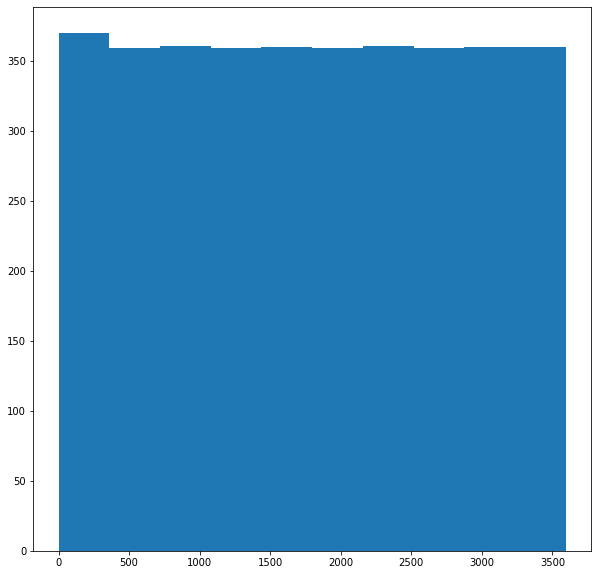

In [18]:
plt.figure(figsize=[10, 10])
plt.hist(meta['popularity'])

In [19]:
le = LabelEncoder()
meta = meta[['adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'popularity', 'release_date', 'runtime', 'status',
       'title', 'vote_average', 'vote_count', 'Action', 'History', 'Adventure',
       'Horror', 'Adult', 'Music', 'Animation', 'Musical', 'Biography',
       'Mystery', 'Comedy', 'Romance', 'Crime', 'Sci-Fi', 'Documentary',
       'Short', 'Drama', 'Sport', 'Family', 'Thriller', 'Fantasy', 'Film-noir',
       'War', 'Western', 'Science Fiction']].apply(le.fit_transform)

In [20]:
X=meta.drop(['popularity'], axis=1)

y=meta['popularity']

X_train, X_test, y_train, y_test=train_test_split(X, y)

In [21]:
print(y)

0       3544
1       3476
2       3400
3       3029
4       3256
        ... 
4684      29
4685    3590
4687    3387
4688     517
4689       0
Name: popularity, Length: 3608, dtype: int64


In [22]:
model=RandomForestClassifier(n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

y_pred=model.predict(X_test)

y_train_pred = model.predict(X_train) 

print("train accuracy: ", accuracy_score(y_train, y_train_pred) )
print("test accuracy", accuracy_score(y_test, y_pred))

train accuracy:  0.4268292682926829
test accuracy 0.0011086474501108647


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         0
          29       0.00      0.00      0.00         1
          32       0.00    

/home/piegarroni/anaconda3/envs/condaenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/piegarroni/anaconda3/envs/condaenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/piegarroni/anaconda3/envs/condaenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start